In [179]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import shap
import math

### Summary characteristics of the patients in this study

In [180]:
DATA_PATH = './data'
df = pd.read_csv(
        Path(DATA_PATH) / 'processed' / 'merged_data_removed_high_missing_features.csv')
# cohort = df.drop(['site_deid', 'subject_deid', 'followup_time'], axis=1)

<AxesSubplot:xlabel='interstage_mortality', ylabel='s1_cpbtime_min'>

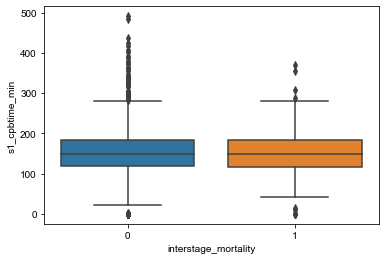

In [181]:
sns.boxplot(y = df['s1_cpbtime_min'], x=df['interstage_mortality'])

<AxesSubplot:xlabel='interstage_mortality', ylabel='year'>

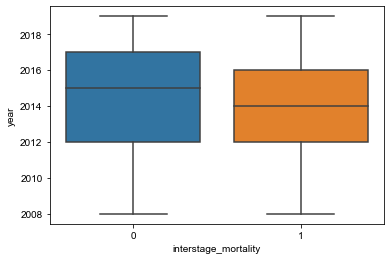

In [182]:
sns.boxplot(y = df['year'], x=df['interstage_mortality'])

In [183]:
df.shape

(3267, 184)

In [184]:
df.head()

,site_deid,subject_deid,fetal_diagnosis,fetal_intervention,fetalintervention_aov,fetalintervention_asd,fetalintervention_pm,fetalintervention_other,year,anomalies_cns,...,Norwood_Sano_DKS_Conduit,s1d_followup_Surgical_Center,s1d_followup_Outside_Center,s1d_followup_comb,s1d_followup_other,hlhs_type_missing_indicator,hlhs_type_MA_AA,hlhs_type_MS_AA,hlhs_type_MA_AS,hlhs_type_MS_AS
0,5,2067,0.0,0.0,0,0,0,0,2014,0,...,0,1,0,0,0,1,0,0,0,0
1,4,1218,1.0,0.0,0,0,0,0,2012,0,...,1,0,0,1,0,0,0,0,1,0
2,34,3932,1.0,0.0,0,0,0,0,2019,0,...,1,1,0,0,0,0,0,1,0,0
3,34,441,NaN,NaN,0,0,0,0,2013,0,...,1,1,0,0,0,0,1,0,0,0
4,3,4400,1.0,0.0,0,0,0,0,2016,0,...,1,1,0,0,0,1,0,0,0,0


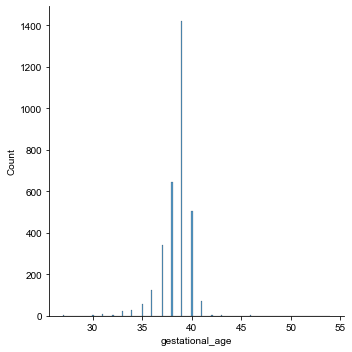

In [185]:
sns.displot(df['gestational_age'])

In [186]:
def _cal_median_quantile(df, feature):
    quantile = df[feature].quantile([0.25,0.5,0.75])
    median = quantile[0.5]
    lcq_low = quantile[0.25]
    lcq_high = quantile[0.75]
    return median, lcq_low, lcq_high

In [187]:
class Cohort:
    def __init__(self,df,outcome, cohort_name=''):
        self.data = df
        self.outcome = outcome
        self.features = list(df.drop(['interstage_mortality'], axis=1).columns)
        self.total_sample_size = self.data.shape[0]
        self.feature_size = self.data.shape[0]-1
        self.cohort_name = cohort_name
        print("%s: total_sample_size %d" % (self.cohort_name, self.total_sample_size))
        
    def get_median_quantile(self,feature):
        median, lcq_low, lcq_high = _cal_median_quantile(self.data,feature)
        print('%s %s: %d (%d, %d)' % (self.cohort_name, feature, median, lcq_low, lcq_high))
        return median, lcq_low, lcq_high
    
    def get_percentage(self,feature):
        fea_unique_values = self.data[feature].unique()
        for f_value in fea_unique_values:
            if math.isnan(f_value):
                sample_size = self.data[feature].isnull().sum()
            else:
                sample_size = self.data[self.data[feature]==f_value].shape[0]   
                
            percentage = sample_size/self.total_sample_size
            print("%s - %s %s: %d (%.1f%%)" % ( self.cohort_name, feature, f_value, sample_size, 100*percentage))
    
    def get_mean_std(self,feature):
        return int(self.data[feature].mean()), self.data[feature].std()

In [188]:
cohort = Cohort(df, 'interstage_mortality', 'Overall')
cases = Cohort(df[df['interstage_mortality']==1], 'interstage_mortality', 'Cases')
controls = Cohort(df[df['interstage_mortality']==0], 'interstage_mortality', 'Controls')

Overall: total_sample_size 3267
Cases: total_sample_size 208
Controls: total_sample_size 3059


In [189]:
cohort.get_median_quantile('gestational_age')
controls.get_median_quantile('gestational_age')
cases.get_median_quantile('gestational_age')

Overall gestational_age: 39 (38, 39)
Controls gestational_age: 39 (38, 39)
Cases gestational_age: 39 (37, 39)


(39.0, 37.0, 39.0)

In [190]:
cohort.get_median_quantile('birthweight')
controls.get_median_quantile('birthweight')
cases.get_median_quantile('birthweight')

Overall birthweight: 3 (3, 4)
Controls birthweight: 3 (3, 4)
Cases birthweight: 3 (3, 3)


(3.0, 3.0, 3.0)

In [191]:
cohort.get_median_quantile('s1_cpbtime_min')
controls.get_median_quantile('s1_cpbtime_min')
cases.get_median_quantile('s1_cpbtime_min')

Overall s1_cpbtime_min: 149 (119, 184)
Controls s1_cpbtime_min: 149 (119, 184)
Cases s1_cpbtime_min: 149 (116, 183)


(149.0, 116.0, 183.0)

In [192]:
#Age at first extubation 
cohort.get_median_quantile('age_at_extubation')
controls.get_median_quantile('age_at_extubation')
cases.get_median_quantile('age_at_extubation')

Overall age_at_extubation: 13 (9, 19)
Controls age_at_extubation: 12 (9, 19)
Cases age_at_extubation: 15 (10, 24)


(15.0, 10.0, 24.0)

In [193]:
#Age at first extubation 
cohort.get_median_quantile('year')
controls.get_median_quantile('year')
cases.get_median_quantile('year')

Overall year: 2015 (2012, 2017)
Controls year: 2015 (2012, 2017)
Cases year: 2014 (2012, 2016)


(2014.0, 2012.0, 2016.0)

In [194]:
cohort.get_percentage('digoxin_at_dc')
controls.get_percentage('digoxin_at_dc')
cases.get_percentage('digoxin_at_dc')

Overall - digoxin_at_dc 0: 1835 (56.2%)
Overall - digoxin_at_dc 1: 1432 (43.8%)
Controls - digoxin_at_dc 0: 1687 (55.1%)
Controls - digoxin_at_dc 1: 1372 (44.9%)
Cases - digoxin_at_dc 0: 148 (71.2%)
Cases - digoxin_at_dc 1: 60 (28.8%)


In [195]:
cohort.get_percentage('sex')
controls.get_percentage('sex')
cases.get_percentage('sex')

Overall - sex 1.0: 2021 (61.9%)
Overall - sex 2.0: 1243 (38.0%)
Overall - sex nan: 3 (0.1%)
Controls - sex 1.0: 1913 (62.5%)
Controls - sex 2.0: 1144 (37.4%)
Controls - sex nan: 2 (0.1%)
Cases - sex 2.0: 99 (47.6%)
Cases - sex 1.0: 108 (51.9%)
Cases - sex nan: 1 (0.5%)


In [196]:
# cohort.get_percentage('race')
# controls.get_percentage('race')
# cases.get_percentage('race')

In [197]:
cohort.get_percentage('ethnicity')
controls.get_percentage('ethnicity')
cases.get_percentage('ethnicity')

Overall - ethnicity 0.0: 2578 (78.9%)
Overall - ethnicity 1.0: 550 (16.8%)
Overall - ethnicity nan: 139 (4.3%)
Controls - ethnicity 0.0: 2422 (79.2%)
Controls - ethnicity 1.0: 506 (16.5%)
Controls - ethnicity nan: 131 (4.3%)
Cases - ethnicity 0.0: 156 (75.0%)
Cases - ethnicity 1.0: 44 (21.2%)
Cases - ethnicity nan: 8 (3.8%)


In [198]:
cohort.get_percentage('Norwood_BT_DKS_Shunt')
controls.get_percentage('Norwood_BT_DKS_Shunt')
cases.get_percentage('Norwood_BT_DKS_Shunt')

Overall - Norwood_BT_DKS_Shunt 0: 2238 (68.5%)
Overall - Norwood_BT_DKS_Shunt 1: 1029 (31.5%)
Controls - Norwood_BT_DKS_Shunt 0: 2110 (69.0%)
Controls - Norwood_BT_DKS_Shunt 1: 949 (31.0%)
Cases - Norwood_BT_DKS_Shunt 0: 128 (61.5%)
Cases - Norwood_BT_DKS_Shunt 1: 80 (38.5%)


In [199]:
cohort.get_percentage('Norwood_Sano_DKS_Conduit')
controls.get_percentage('Norwood_Sano_DKS_Conduit')
cases.get_percentage('Norwood_Sano_DKS_Conduit')

Overall - Norwood_Sano_DKS_Conduit 0: 1344 (41.1%)
Overall - Norwood_Sano_DKS_Conduit 1: 1923 (58.9%)
Controls - Norwood_Sano_DKS_Conduit 0: 1220 (39.9%)
Controls - Norwood_Sano_DKS_Conduit 1: 1839 (60.1%)
Cases - Norwood_Sano_DKS_Conduit 0: 124 (59.6%)
Cases - Norwood_Sano_DKS_Conduit 1: 84 (40.4%)


In [200]:
cohort.get_percentage('Norwood_Hybrid')
controls.get_percentage('Norwood_Hybrid')
cases.get_percentage('Norwood_Hybrid')

Overall - Norwood_Hybrid 1: 243 (7.4%)
Overall - Norwood_Hybrid 0: 3024 (92.6%)
Controls - Norwood_Hybrid 1: 204 (6.7%)
Controls - Norwood_Hybrid 0: 2855 (93.3%)
Cases - Norwood_Hybrid 1: 39 (18.8%)
Cases - Norwood_Hybrid 0: 169 (81.2%)


In [201]:
cohort.get_percentage('Norwood_Central_Shunt')
controls.get_percentage('Norwood_Central_Shunt')
cases.get_percentage('Norwood_Central_Shunt')

Overall - Norwood_Central_Shunt 0: 3244 (99.3%)
Overall - Norwood_Central_Shunt 1: 23 (0.7%)
Controls - Norwood_Central_Shunt 0: 3038 (99.3%)
Controls - Norwood_Central_Shunt 1: 21 (0.7%)
Cases - Norwood_Central_Shunt 0: 206 (99.0%)
Cases - Norwood_Central_Shunt 1: 2 (1.0%)


In [202]:
cohort.get_median_quantile('age_at_norwood')
controls.get_median_quantile('age_at_norwood')
cases.get_median_quantile('age_at_norwood')

Overall age_at_norwood: 5 (4, 8)
Controls age_at_norwood: 5 (4, 8)
Cases age_at_norwood: 6 (4, 8)


(6.0, 4.0, 8.0)

In [203]:
#AV valve regurgitation
cohort.get_percentage('avvr_at_discharge')
controls.get_percentage('avvr_at_discharge')
cases.get_percentage('avvr_at_discharge')

Overall - avvr_at_discharge nan: 1182 (36.2%)
Overall - avvr_at_discharge 3.0: 332 (10.2%)
Overall - avvr_at_discharge 2.0: 810 (24.8%)
Overall - avvr_at_discharge 1.0: 929 (28.4%)
Overall - avvr_at_discharge 4.0: 14 (0.4%)
Controls - avvr_at_discharge nan: 1089 (35.6%)
Controls - avvr_at_discharge 3.0: 301 (9.8%)
Controls - avvr_at_discharge 2.0: 765 (25.0%)
Controls - avvr_at_discharge 1.0: 892 (29.2%)
Controls - avvr_at_discharge 4.0: 12 (0.4%)
Cases - avvr_at_discharge 3.0: 31 (14.9%)
Cases - avvr_at_discharge nan: 93 (44.7%)
Cases - avvr_at_discharge 1.0: 37 (17.8%)
Cases - avvr_at_discharge 2.0: 45 (21.6%)
Cases - avvr_at_discharge 4.0: 2 (1.0%)


In [204]:
cohort.get_percentage('function_at_discharge')
controls.get_percentage('function_at_discharge')
cases.get_percentage('function_at_discharge')

Overall - function_at_discharge 1.0: 1886 (57.7%)
Overall - function_at_discharge nan: 1152 (35.3%)
Overall - function_at_discharge 3.0: 55 (1.7%)
Overall - function_at_discharge 2.0: 166 (5.1%)
Overall - function_at_discharge 4.0: 8 (0.2%)
Controls - function_at_discharge 1.0: 1789 (58.5%)
Controls - function_at_discharge nan: 1063 (34.7%)
Controls - function_at_discharge 3.0: 52 (1.7%)
Controls - function_at_discharge 2.0: 147 (4.8%)
Controls - function_at_discharge 4.0: 8 (0.3%)
Cases - function_at_discharge 1.0: 97 (46.6%)
Cases - function_at_discharge nan: 89 (42.8%)
Cases - function_at_discharge 2.0: 19 (9.1%)
Cases - function_at_discharge 3.0: 3 (1.4%)


In [205]:
#Required Cath during interstage
cohort.get_percentage('s1_postop_cath')
controls.get_percentage('s1_postop_cath')
cases.get_percentage('s1_postop_cath')

Overall - s1_postop_cath 0.0: 2578 (78.9%)
Overall - s1_postop_cath 1.0: 661 (20.2%)
Overall - s1_postop_cath nan: 28 (0.9%)
Controls - s1_postop_cath 0.0: 2439 (79.7%)
Controls - s1_postop_cath 1.0: 596 (19.5%)
Controls - s1_postop_cath nan: 24 (0.8%)
Cases - s1_postop_cath 0.0: 139 (66.8%)
Cases - s1_postop_cath 1.0: 65 (31.2%)
Cases - s1_postop_cath nan: 4 (1.9%)


In [206]:
cohort.get_percentage('syndrome_any')
controls.get_percentage('syndrome_any')
cases.get_percentage('syndrome_any')

Overall - syndrome_any 0: 2938 (89.9%)
Overall - syndrome_any 1: 329 (10.1%)
Controls - syndrome_any 0: 2762 (90.3%)
Controls - syndrome_any 1: 297 (9.7%)
Cases - syndrome_any 0: 176 (84.6%)
Cases - syndrome_any 1: 32 (15.4%)


In [207]:
#O2 saturation at discharge
cohort.get_median_quantile('s1d_spo2')
controls.get_median_quantile('s1d_spo2')
cases.get_median_quantile('s1d_spo2')

Overall s1d_spo2: 83 (80, 86)
Controls s1d_spo2: 83 (80, 86)
Cases s1d_spo2: 82 (79, 85)


(82.0, 79.0, 85.0)

In [208]:
#Cross clamp time
cohort.get_median_quantile('s1_xclamptime_min')
controls.get_median_quantile('s1_xclamptime_min')
cases.get_median_quantile('s1_xclamptime_min')

Overall s1_xclamptime_min: 62 (47, 81)
Controls s1_xclamptime_min: 61 (47, 81)
Cases s1_xclamptime_min: 65 (45, 84)


(65.0, 45.25, 84.0)

In [209]:
# cohort.get_percentage('Norwood_DKS_Shunt')
# controls.get_percentage('Norwood_DKS_Shunt')
# cases.get_percentage('Norwood_DKS_Shunt')

In [210]:
# cohort.get_percentage('Norwood_Sano')
# controls.get_percentage('Norwood_Sano')
# cases.get_percentage('Norwood_Sano')

In [211]:
# cohort.get_percentage('Norwood_DKS_Conduit')
# controls.get_percentage('Norwood_DKS_Conduit')
# cases.get_percentage('Norwood_DKS_Conduit')

In [212]:
from scipy.stats import ttest_ind_from_stats as t_test
def compute_pvalue(cases, controls):
    for f in ['gestational_age', 'birthweight']:
        _, p_value = t_test(mean1=cases.get_mean_std(f)[0], 
               std1=cases.get_mean_std(f)[1],
               nobs1=cases.total_sample_size, 
               mean2=controls.get_mean_std(f)[0], 
               std2=controls.get_mean_std(f)[1],
               nobs2=controls.total_sample_size) 
        print(f, p_value)

In [213]:
cases.get_mean_std('gestational_age')[0]

37

In [214]:
compute_pvalue(cases,controls)

gestational_age 4.2169100091511223e-20
birthweight 1.0


In [215]:
# def get_feature_distribution(df, feature):
#     median, lcq_low, lcq_high = get_median_quantile(df,feature)
#     print(' %d (%d, %d)' % (median, lcq_low, lcq_high))

# def print_feature_distribution(feature):   
#     print("Overal", get_feature_distribution(cohort,feature))
#     print("Cases", get_feature_distribution(cases, feature))
#     print("Controls", get_feature_distribution(controls, feature))

In [216]:
# feature = 'gestational_age'
# median, lcq_low, lcq_high = get_median_quantile(df,feature)
# print('%d (%d, %d)' % (median, lcq_low, lcq_high))

### Build summary plots
Generating explanations for multiple iterations and condensing in one plot.

In [217]:
result_path = Path('./result/benchmark')

In [218]:
list_shap_values = []
list_train_sets = []
# list_test_sets = []

for split in range(0,5):
    for fold in range (0,5):
        shap_values = np.load(result_path / 'lightGBM_shap_values_on_train_split_{}_run_fold_{}.npy'.format(split,fold))
#         X_test = np.load(result_path / 'X_test_on_test_split_{}.npy'.format(split))
        X_train = np.load(result_path / 'X_train_on_train_split_{}_run_fold_{}.npy'.format(split, fold))
        list_shap_values.append(shap_values)
#         list_test_sets.append(X_test)
        list_train_sets.append(X_train)

    # test_set = list_test_sets[0]
train_set = list_train_sets[0]
shap_values = np.array(list_shap_values[0])
for i in range(1,len(list_train_sets)):
#     test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
    train_set = np.concatenate((train_set,list_train_sets[i]),axis=0)
    shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=1)
#bringing back variable names
# X_test = pd.DataFrame(test_set)
X_train = pd.DataFrame(train_set)
X_train.shape

(52260, 180)

In [219]:
DATA_PATH = './data'
df = pd.read_csv(
        Path(DATA_PATH) / 'processed' / 'merged_data_removed_high_missing_features.csv') #'merged_data_removed_high_missing_features.csv'
feature_names = list(df.drop(['site_deid', 'subject_deid', 'followup_time', 'interstage_mortality'], axis=1).columns)
X_train = pd.DataFrame(train_set, columns = feature_names)
X_train.shape

(52260, 180)

In [220]:
for idx, f in enumerate(feature_names):
    if f == 's1_cpbtime_min':
        print(idx)

64


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


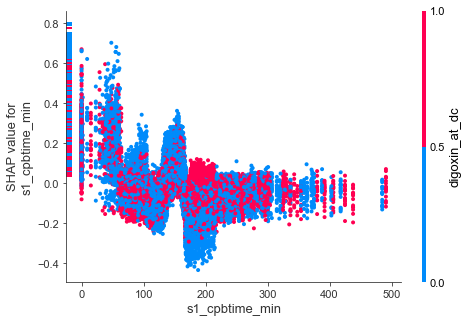

In [221]:
shap.dependence_plot(64, shap_values[1], X_train)

In [222]:
X_train.iloc[:,64]

0        199.0
1        164.0
2        156.0
3         74.0
4        165.0
         ...  
52255    130.0
52256    189.0
52257    115.0
52258    180.0
52259    246.0
Name: s1_cpbtime_min, Length: 52260, dtype: float64

In [223]:
fig = plt.figure(figsize=(10,14))
#creating explanation plot for the whole experiment, the first dimension from shap_values indicate the class we are predicting (0=0, 1=1)
# shap.summary_plot(shap_values[1], X_train)

<Figure size 720x1008 with 0 Axes>

In [224]:
def replace_names(my_list, source, target):
    for i, item in enumerate(my_list):
        if item == source:
            my_list[i] = target
    return my_list
            
def formulate_feature_name(feature_list):
    feature_list = replace_names(feature_list, 'digoxin_at_dc', 'Digoxin use at discharge')
    feature_list = replace_names(feature_list, 'length_at_discharge', 'Length at discharge')
    feature_list = replace_names(feature_list, 'year', 'Operative year')
    feature_list = replace_names(feature_list, 's1_postop_cath', 'Interstage catheterization')
    feature_list = replace_names(feature_list, 'norwood_type', 'Norwood with BTT shunt')
    feature_list = replace_names(feature_list, 's1_cpbtime_min', 'CBP time')
    feature_list = replace_names(feature_list, 'gestational_age', 'Gestational age')
    feature_list = replace_names(feature_list, 'sex', 'Female')
    feature_list = replace_names(feature_list, 'age_s1_admit', 'Not born at stage I palliation hospital')
    # changed 
    feature_list = replace_names(feature_list, 'antibiotics_at_dc', 'Antibiotic use at discharge')
    feature_list = replace_names(feature_list, 'age_at_stage1_discharge', 'Age at discharge')
    feature_list = replace_names(feature_list, 's1dtarcal', 'Target caloric density at discharge')
    feature_list = replace_names(feature_list, 's1_xclamptime_min', 'Stage I cross-clamp time')
    feature_list = replace_names(feature_list, 's1d_spo2', 'Oxygen saturation at discharge')
#     feature_list =  replace_names(feature_list, 's1d_followup', 'Interstage follow-up not at stage I hospital')
    feature_list = replace_names(feature_list, 's1_circarresttime_min', 'Stage I circulatory arrest time')
    feature_list = replace_names(feature_list, 's1d_nut_typ', 'Formula feeds')
    feature_list = replace_names(feature_list, 'age_at_norwood', 'Age at stage I surgery')
    feature_list = replace_names(feature_list, 'avvr_at_discharge', 'AVVI at discharg') #Degree of AV valve regurgitation at discharge
    feature_list = replace_names(feature_list, 'nutrition_route', 'Not taking oral feeds')
    feature_list = replace_names(feature_list, 'birthweight', 'Birth weight')
    feature_list = replace_names(feature_list, 'diagnosis', 'Diagnosis')
    feature_list = replace_names(feature_list, 'age_postop_feeds_start', 'Age when feeds restarted post-op')
    feature_list = replace_names(feature_list, 'age_at_extubation', 'Age at first extubation post-op')
    feature_list = replace_names(feature_list, 's1comp_arr', 'Post-op arrhythmia')
    feature_list = replace_names(feature_list, 'Norwood_Sano_DKS_Conduit', 'Norwood/Sano, DKS/Conduit')
    feature_list = replace_names(feature_list, 'Norwood_Hybrid', 'Hybrid')
#     feature_list = replace_names(feature_list, 'race', 'Race')
    return feature_list
            

In [225]:
name_map = formulate_feature_name(feature_names)
X_train = pd.DataFrame(train_set, columns = name_map)

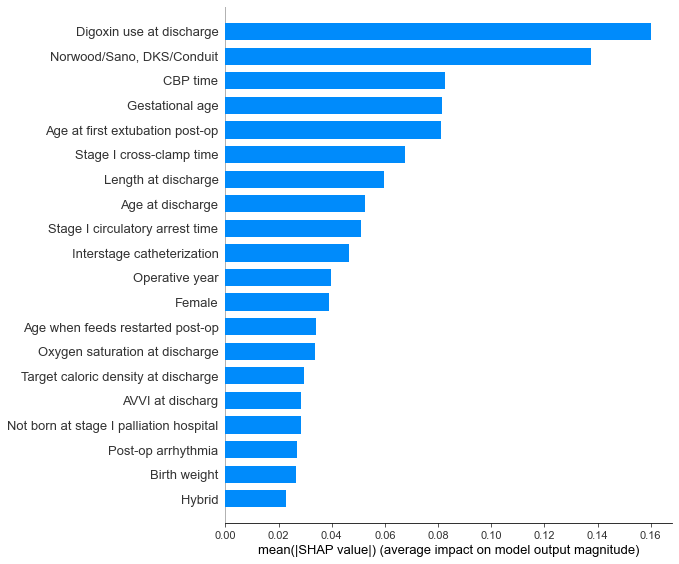

In [226]:
# figure with feature formated for display in publication
plt.rcParams.update({'font.family':'Arial'})
f = plt.figure(figsize=(4,6))
shap.summary_plot(shap_values[1], X_train, plot_type='bar',
                        max_display=20, plot_size="auto", show=False)
plt.savefig("result/raw_figures/lgbm_summary_bar.pdf", dpi=400, bbox_inches='tight')
plt.savefig("result/raw_figures/lgbm_summary_bar.eps", dpi=400, bbox_inches='tight')
plt.show()

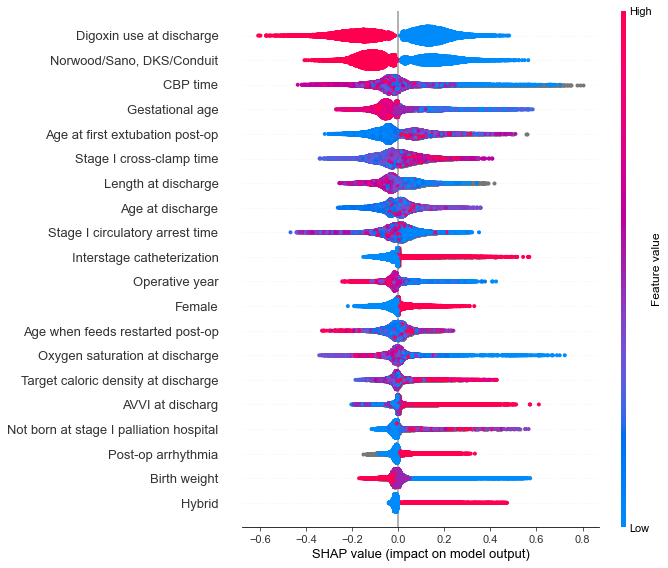

In [227]:
f = plt.figure(figsize=(5,6))
shap.summary_plot(shap_values[1], X_train,max_display=20, plot_size="auto", show=False)
plt.savefig("result/raw_figures/lgbm_summary_dot.pdf", dpi=400, bbox_inches='tight')
plt.savefig("result/raw_figures/lgbm_summary_dot.eps", dpi=400, bbox_inches='tight')
plt.show()

In [228]:
X_train

,fetal_diagnosis,fetal_intervention,fetalintervention_aov,fetalintervention_asd,fetalintervention_pm,fetalintervention_other,Operative year,anomalies_cns,anomalies_gi,anomalies_renal_gu,...,"Norwood/Sano, DKS/Conduit",s1d_followup_Surgical_Center,s1d_followup_Outside_Center,s1d_followup_comb,s1d_followup_other,hlhs_type_missing_indicator,hlhs_type_MA_AA,hlhs_type_MS_AA,hlhs_type_MA_AS,hlhs_type_MS_AS
0,1.0,0.0,0.0,0.0,0.0,0.0,2019.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,2015.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,2018.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,2012.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,2011.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52255,1.0,0.0,0.0,0.0,0.0,0.0,2012.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
52256,1.0,0.0,0.0,0.0,0.0,0.0,2014.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
52257,1.0,0.0,0.0,0.0,0.0,0.0,2014.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
52258,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [229]:
import numpy as np
import scipy.stats as st

#define sample data
data = [12, 12, 13, 13, 15, 16, 17, 22, 23, 25, 26, 27, 28, 28, 29]

#create 95% confidence interval for population mean weight
confidence_interval= st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))
print('%.3f (%.3f-%.3f) ' % (np.mean(data), confidence_interval[0],confidence_interval[1]))

20.400 (16.758-24.042) 


In [230]:
confidence_interval[0]

16.75776979778498

In [231]:
a = []
data = ['12', 12, 13, 13, 15, 16, 17, 22, 23, 25, 26, 27, 28, 28, 29]
a.extend(data)
a.extend(data)